## **NYU Depth dataset Explorer**

In this notebook we will explore the NYU Indoor Depth and Segmentation dataset.

Paper: https://cs.nyu.edu/~silberman/papers/indoor_seg_support.pdf <br>
Download Source: https://cs.nyu.edu/~silberman/datasets/nyu_depth_v2.html

In [1]:
import os
import sys 

import numpy as np
import h5py
import cv2

import torch 
from torch.utils.data import Dataset
from torchvision import transforms

import matplotlib as mpl
import matplotlib.pyplot as plt

# local imports
sys.path.append('..')

from nyu_dataset import NyuDataset
from utils import *


%matplotlib inline

In [2]:
os.path.exists('../data_exploration')

True

## Load Data and Display a sample

In [3]:
# image net
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
    transforms.ToTensor(),
    # transforms.Resize((240, 320)),
])

In [6]:
root = r"C:\Users\itber\Documents\datasets\nyu_depth_seg\nyu_depth_v2_labeled.mat"
nyu_dataset = NyuDataset(root, transform=transform)

In [7]:
idx = 100 # 125
image, (depth, label) = nyu_dataset[idx]

# get format for display
image_np, depth_np, label_np = convert_to_numpy(image, depth, label)

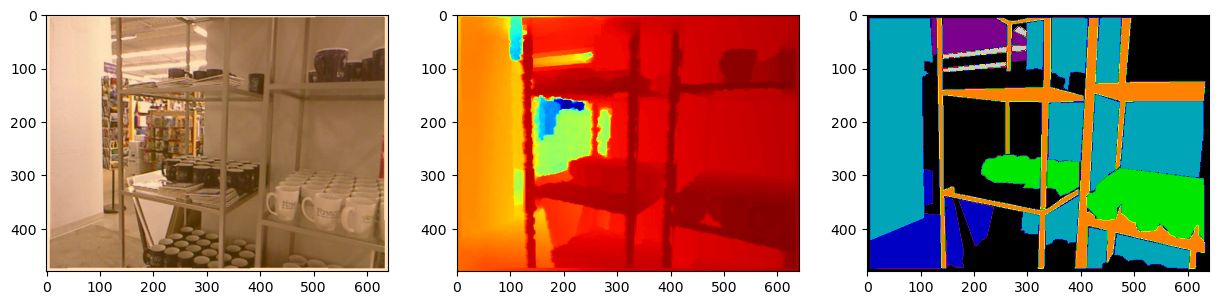

In [8]:
_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(image_np)
ax[1].imshow(depth_np, cmap='jet_r')
ax[2].imshow(label_np, cmap='nipy_spectral');

## Get Train/Test split and inspect the data

In [9]:
from torch.utils.data import random_split

seed = 42

# get train split
num_train = round(0.7*len(nyu_dataset))
num_remain = round(0.3*len(nyu_dataset))
(train_dataset, remain_dataset) = random_split(nyu_dataset,
                                               [num_train, num_remain],
                                               generator=torch.Generator().manual_seed(seed))

# get valid and test split
num_valid = round(0.8*len(remain_dataset))
num_test = round(0.2*len(remain_dataset))
(valid_dataset, test_dataset) = random_split(remain_dataset,
                                             [num_valid, num_test],
                                              generator=torch.Generator().manual_seed(seed))

In [10]:
min_depths = []
max_depths = []
all_labels = []
for i in range(len(train_dataset)):
    image, (depth, label) = nyu_dataset[i]

    min_depths.append(depth.min().item())
    max_depths.append(depth.max().item())

    all_labels += label.ravel().numpy().astype(np.int16).tolist()

Display min/max depths

In [10]:
min(min_depths), max(max_depths)

(0.7132995128631592, 9.99547004699707)

Get Class Frequencies

In [11]:
class_counts = np.bincount(all_labels)

In [12]:
class_counts.shape

(800,)

##### Plot all Class Frequencies

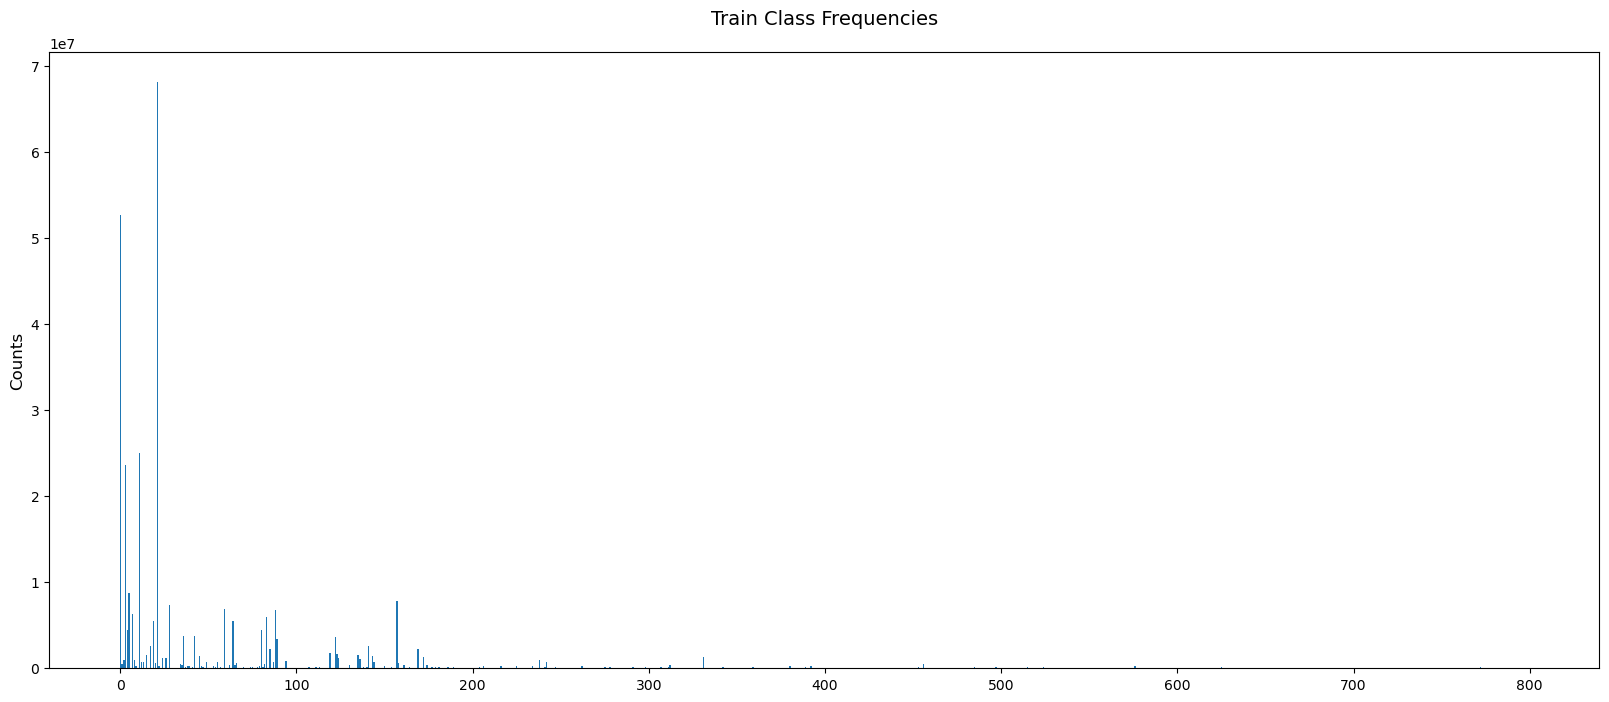

In [13]:
plt.figure(figsize=(20, 8))
plt.bar(np.arange(0, len(class_counts)), class_counts)
plt.ylabel('Counts', size=12)
plt.title('Train Class Frequencies', size=14, pad=20);

#### Plot Top 50 class frequencies

In [15]:
sorted_classes = np.argsort(class_counts)[::-1]
topk = 50

In [16]:
categories = {}
for cat in sorted_classes[:topk]:
    categories.update({nyu_dataset.str_label(cat) : cat})

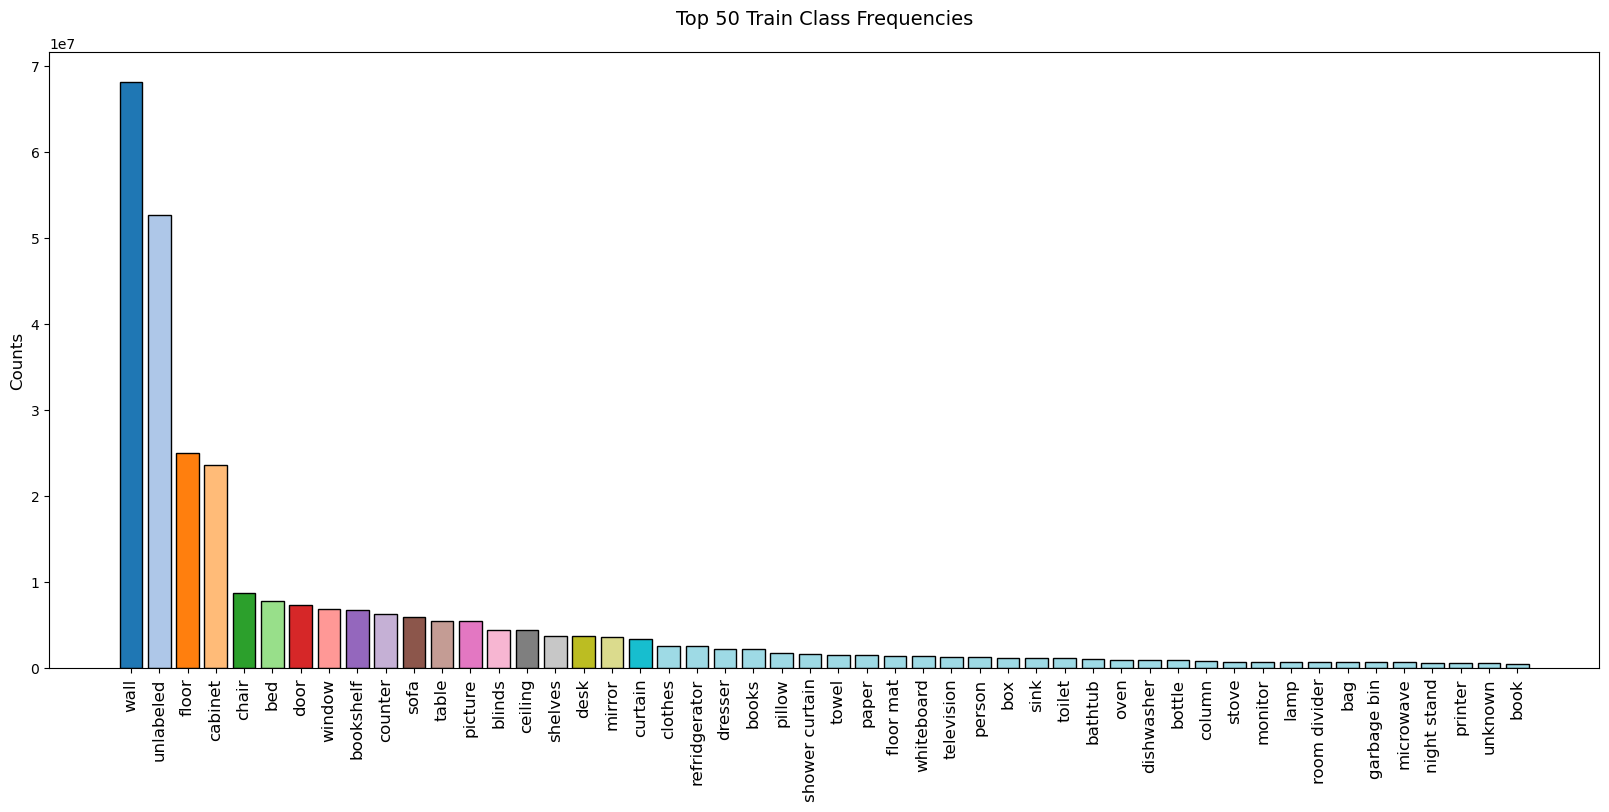

In [17]:
plt.figure(figsize=(20, 8))
plt.bar(list(categories.keys()), class_counts[sorted_classes][:topk], 
             color=mpl.cm.tab20(np.arange(0, topk)),
             edgecolor='black')
plt.xticks(list(categories.keys()), list(categories.keys()), size=12, rotation=90)
plt.ylabel('Counts', size=12)
plt.title('Top 50 Train Class Frequencies', size=14, pad=20);

# set ylim for better viz
# plt.ylim(0, 1e6);

## Clean the Dataset

This dataset has way too many classes and is way too small for deep learning. To improve the chances of training a decent model, we will need to reduce the total number of classes. We could do this in two different ways:

- Hard way: Use an NLP embedding model to find semantically similar categories and aggregate them together. i.e monitor and television. Then we could manually review this and create a dataset with a limited number of classes.

- Easy way: Just use the top k classes and place the rest into unlabeled.

- (BONUS) Even easier: Just use this 13 class version of the dataset: https://github.com/ankurhanda/nyuv2-meta-data

In this case, we will go with option 2 and just use the Top K classes. To do this, we will just modify the classes to corresposonf to lists, and for every class greater than K, we make it correspond to the unlabeled class.

In [18]:
topk = 50
topk_labels = []
categories = {}

for i, cat in enumerate(sorted_classes):
    if i < topk:
        topk_labels.append(cat)
        categories.update({nyu_dataset.str_label(cat) : [cat]})
    else:
        categories['unlabeled'].append(cat)

Test out the approach

In [21]:
tmp = label_np.copy()

for lbl in np.unique(tmp).astype(int):
    print(lbl, lbl in topk_labels) 
    if lbl not in topk_labels:
        tmp[tmp == lbl] = 0

0 True
4 True
11 True
21 True
35 False
50 False
62 False


In [22]:
np.unique(label_np), np.unique(tmp)

(array([ 0.,  4., 11., 21., 35., 50., 62.], dtype=float32),
 array([ 0.,  4., 11., 21.], dtype=float32))

Since we are working with a training split, we will choose to obtain/define the topk labels outside of the dataloader and pass it in as an argument.

In [23]:
nyu_dataset_topk = NyuDataset(root, topk_labels=topk_labels, transform=transform)

In [24]:
idx = 100 # 125

image, (depth, label) = nyu_dataset[idx]
image2, (depth2, label2) = nyu_dataset_topk[idx]

# get format for display
image_np, depth_np, label_np = convert_to_numpy(image, depth, label)
image2_np, depth2_np, label2_np = convert_to_numpy(image2, depth2, label2)

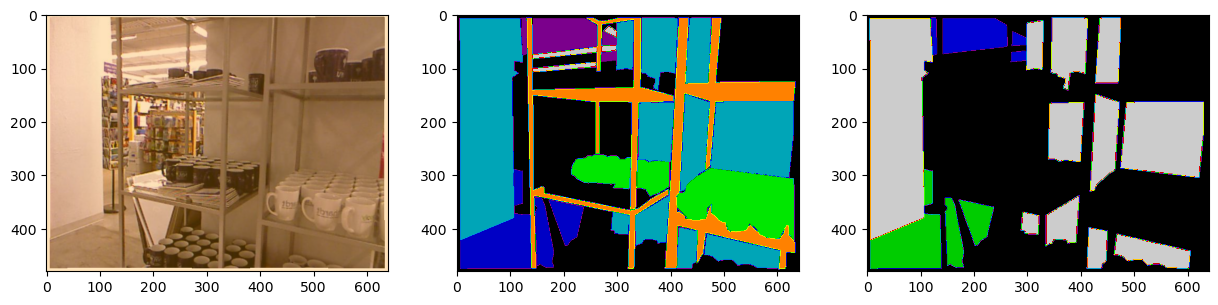

In [25]:
_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(image_np)
ax[1].imshow(label_np, cmap='nipy_spectral')
ax[2].imshow(label2_np, cmap='nipy_spectral');

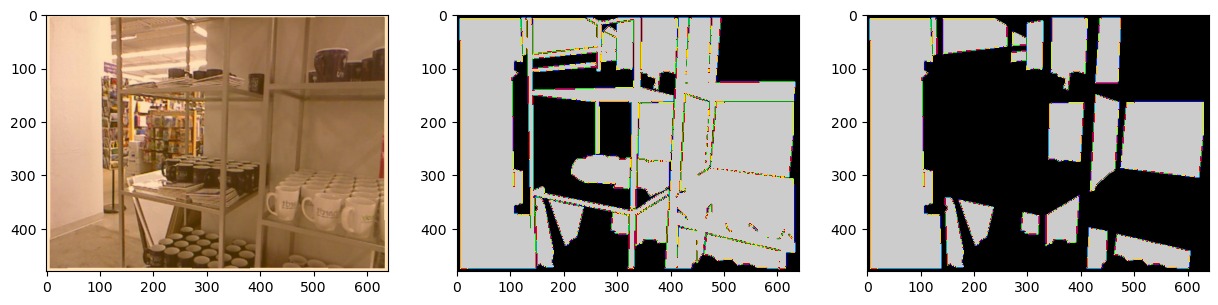

In [26]:
_, ax = plt.subplots(1, 3, figsize=(15, 8))
ax[0].imshow(image_np)
ax[1].imshow(label_np != 0, cmap='nipy_spectral')
ax[2].imshow(label2_np != 0, cmap='nipy_spectral');